In [1]:
from common import NWSL, Data, Colors, Fonts, Images, add_signature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def calc_result(row, team):
    opp = "away" if team == "home" else "home"
    if row[team + "_score"] > row[opp + "_score"]:
        return "W"
    elif row[team + "_score"] < row[opp + "_score"]:
        return "L"
    elif not row["is_playoffs"]:
        return "D"
    elif row[team + "_penalty_score"] > row[opp + "_penalty_score"]:
        return "W"
    elif row[team + "_penalty_score"] < row[opp + "_penalty_score"]:
        return "L"
    else:
        print(row)
        raise Exception("Can't calculate score")


def get_results(season=None):
    df = Data.get_nwsl_matches(season=season)

    df["home_result"] = df.apply(lambda r: calc_result(r, "home"), axis=1)
    df["away_result"] = df.apply(lambda r: calc_result(r, "away"), axis=1)

    # Remove extra columns
    df = df[["date", "home", "away", "home_result", "away_result"]]

    # Rename home and away to match
    df = pd.concat(
        [
            df.rename(
                columns={"home": "team", "away": "opponent", "home_result": "result"}
            ),
            df.rename(
                columns={"away": "team", "home": "opponent", "away_result": "result"}
            ),
        ]
    )[["date", "team", "opponent", "result"]]

    # Aggregate
    df = (
        df.groupby(["team", "opponent", "result"])
        .agg(count=("date", "count"))
        .reset_index()
    )
    return df

In [9]:
custom_dict = {"W": 0, "D": 1, "L": 3}


def get_head_to_head(a, b, season=None):
    df = get_results(season)
    res = df[(df["team"] == a) & (df["opponent"] == b)].reset_index(drop=True)
    for x in ["W", "D", "L"]:
        if x not in list(res["result"]):
            res.loc[len(res.index)] = [a, b, x, 0]
    res = res.sort_values(by=["result"], key=lambda x: x.map(custom_dict))
    
    return res

In [10]:
get_head_to_head("WAS", "GFC")

,team,opponent,result,count
2,WAS,GFC,W,17
0,WAS,GFC,D,8
1,WAS,GFC,L,13


In [11]:
get_head_to_head("WAS", "GFC", season="2024")

,team,opponent,result,count
0,WAS,GFC,W,2
1,WAS,GFC,D,0
2,WAS,GFC,L,0


In [12]:
get_head_to_head("ORL", "KCC")

,team,opponent,result,count
2,ORL,KCC,W,3
0,ORL,KCC,D,3
1,ORL,KCC,L,2


In [13]:
get_head_to_head("ORL", "KCC", season="2024")

,team,opponent,result,count
1,ORL,KCC,W,1
0,ORL,KCC,D,1
2,ORL,KCC,L,0


<ipython-input-16-ae830efa41a3>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([NWSL.name(t1) + "\nWin", "Draw", NWSL.name(t2) + "\nWin"])


<Figure size 864x864 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

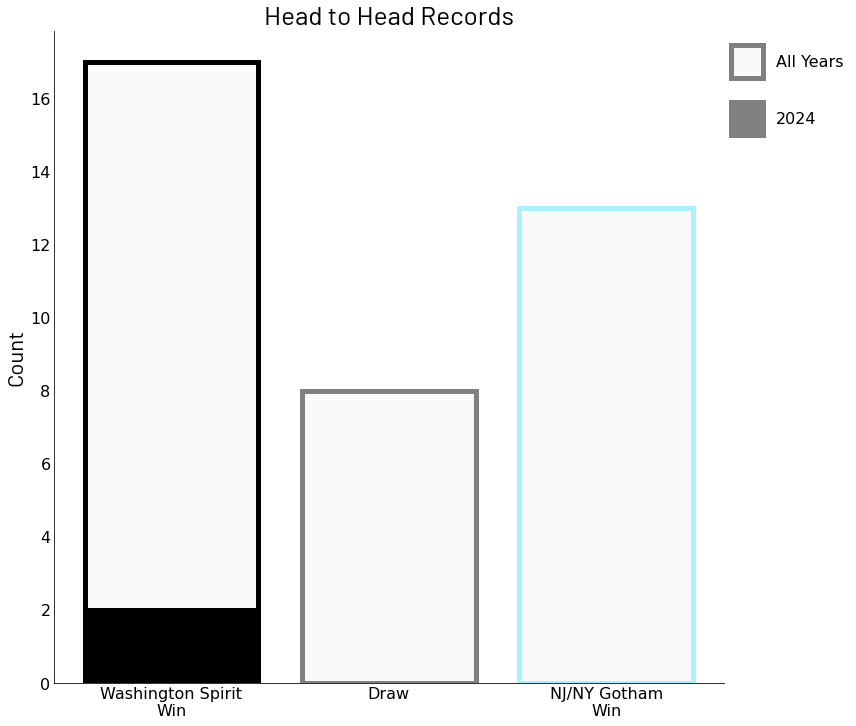

In [16]:
def plot_head_to_head(t1, t2):
    plt.clf()
    plt.rcParams["figure.figsize"] = (12, 12)
    plt.figure(dpi=300)
    fig, ax = plt.subplots()
    
    plt.rcParams["legend.handlelength"] = 2 * 1
    plt.rcParams["legend.handleheight"] = 2 * 1.4

    data = get_head_to_head(t1, t2)

    for i, row in data.iterrows():
        color = (
            Colors.GRAY
            if row["result"] == "D"
            else NWSL.color(row["team"] if row["result"] == "W" else row["opponent"])
        )
        b = ax.bar(
            row["result"],
            row["count"],
            edgecolor=color,
            color=Colors.WHITE,
            label="All Years" if row["result"] == "D" else None,
        )
        b[0].set_linewidth(5)

    data_2023 = get_head_to_head(t1, t2, season="2024")
    for i, row in data_2023.iterrows():
        color = (
            Colors.GRAY
            if row["result"] == "D"
            else NWSL.color(row["team"] if row["result"] == "W" else row["opponent"])
        )
        b = ax.bar(
            row["result"],
            row["count"],
            edgecolor=color,
            color=color,
            label="2024" if row["result"] == "D" else None,
        )
        b[0].set_linewidth(5)

    ax.set_title("Head to Head Records", fontproperties=Fonts.BARLOW, size=26)
    ax.set_ylabel("Count", fontproperties=Fonts.BARLOW, size=22)
    ax.set_xticklabels([NWSL.name(t1) + "\nWin", "Draw", NWSL.name(t2) + "\nWin"])
    ax.tick_params(axis="both", which="major", labelsize=16, length=0)
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend(
        frameon=False, labelspacing=1.5, prop={"size": 16}, bbox_to_anchor=(1.2, 1)
    )

    

    # Save image
    plt.savefig(
        "head_to_head_togethxr_" + t1 + "_" + t2 + ".png",
        bbox_inches="tight",
        pad_inches=0.5,
        transparent=True,
    )


plot_head_to_head("WAS", "GFC")

<ipython-input-16-ae830efa41a3>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([NWSL.name(t1) + "\nWin", "Draw", NWSL.name(t2) + "\nWin"])


<Figure size 864x864 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

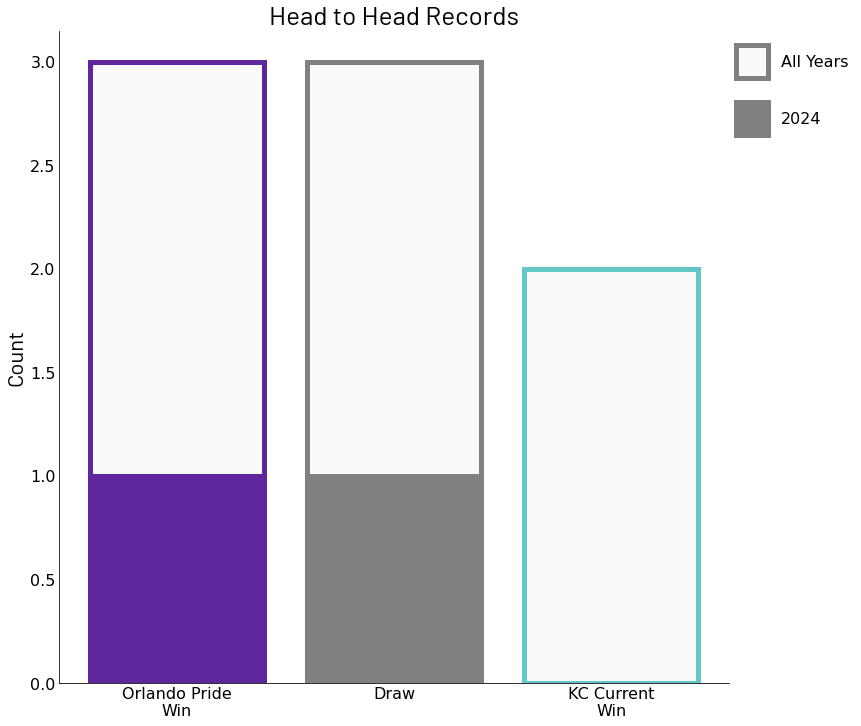

In [18]:
plot_head_to_head("ORL", "KCC")

<Figure size 864x576 with 0 Axes>

<Figure size 2400x1600 with 0 Axes>

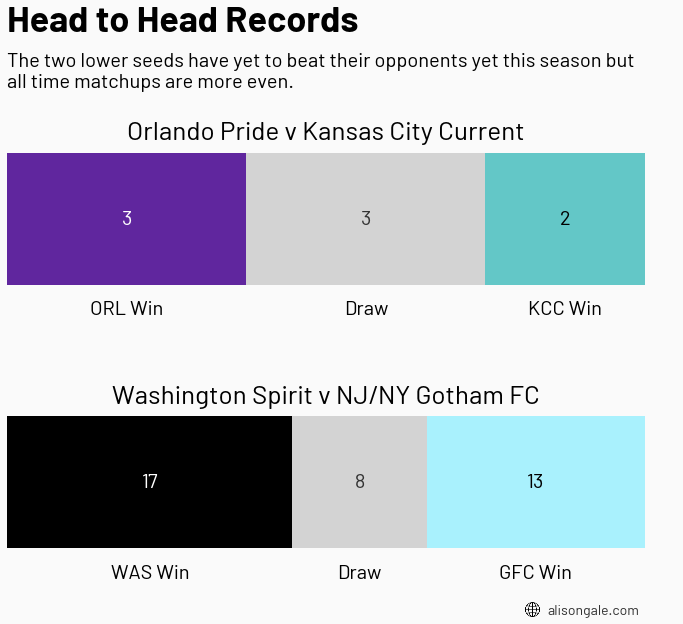

In [33]:
plt.clf()
plt.rcParams["figure.figsize"] = (12, 8)
plt.figure(dpi=200, facecolor=Colors.WHITE)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)


WIN_COLORS = [NWSL.color("ORL"), NWSL.color("WAS")]
DRAW_COLORS = [Colors.LIGHT_GRAY, Colors.LIGHT_GRAY]
LOSS_COLORS = [NWSL.color("KCC"), NWSL.color("GFC")]

for (t1, t2) in [("ORL", "KCC"), ("WAS", "GFC")]:
    d1 = get_head_to_head(t1, t2)
    d1["percent"] = d1["count"] / d1["count"].sum()

    starts = np.zeros(1)
    for i in ["W", "D", "L"]:
        colors = {
            "W": NWSL.color(t1),
            "D": Colors.LIGHT_GRAY,
            "L": NWSL.color(t2),
        }
        text_colors = {
            "W": NWSL.text_color(t1),
            "D": Colors.BLACK,
            "L": NWSL.text_color(t2),
        }
        label = d1[d1["result"] == i].iloc[0]["count"]
        rects = ax.barh(
            [1.5 if t1 == "ORL" else 1],
            [d1[d1["result"] == i].iloc[0]["percent"]],
            left=starts,
            height=0.25,
            color=[colors[i]],
            label=[label],
        )
        ax.bar_label(
            rects,
            labels=[label if label > 0 else ""],
            label_type="center",
            color=text_colors[i],
            fontproperties=Fonts.BARLOW,
            size=20,
        )
        if label > 0:
            plt.text(
                rects[0].get_x() + rects[0].get_width() / 2.0,
                rects[0].get_y() - 0.03,
                t1 + " Win" if i == "W" else (t2 + " Win" if i == "L" else "Draw"),
                ha="center",
                va="top",
                fontproperties=Fonts.BARLOW,
                size=20,
            )

        starts += [d1[d1["result"] == i].iloc[0]["percent"]]
        
ax.axis("off")

plt.text(
    0.5,
    1.65,
    "Orlando Pride v Kansas City Current",
    ha="center",
    va="baseline",
    fontproperties=Fonts.BARLOW,
    size=26,
)

plt.text(
    0.5,
    1.15,
    "Washington Spirit v NJ/NY Gotham FC",
    ha="center",
    va="baseline",
    fontproperties=Fonts.BARLOW,
    size=26,
)

ax.set_title(
    "Head to Head Records",
    fontproperties=Fonts.BARLOW_BOLD,
    size=36,
    ha="left",
    x=0,
    y=1.22,
)

# Subtitle
ax.text(
    0,
    1.75,
    "The two lower seeds have yet to beat their opponents yet this season but\nall time matchups are more even.",
    fontproperties=Fonts.BARLOW,
    size=20,
    ha="left",
)

add_signature(fig, x=0.72, y=0.04, fs=14, w=0.025)

# Save image
plt.savefig(
    "head_to_head_2024.png",
    bbox_inches="tight",
    pad_inches=0.5,
)